# Casos de Uso de la teoría de Información y en concreto de la Entropia de Shannon en ML <a name="introduction"></a>

# Índice
1. [Introducción](#introduction)
2. [Casos de Uso](#casos)
    1. [Librerias Y Funciones](#librerias)
    2. [Cantidad de Información](#informacion)
    3. [Información mútua](#informacionmutua)
    4. [Ganancia Información](#gananciainformacion)
    5. [Clustering & Feature Selection](#clusteringn)
    6. [Feature Selection](#feature)


> El objetivo de este notebook es dispensar algunos de los casos en los que el uso de la entropía de Shannon puede derivar en ciertos beneficios en proyectos de ML. 
***

**Definición:**
En el ámbito de la teoría de la información la entropía, también llamada entropía de la información y entropía de Shannon (en honor a Claude E. Shannon), mide la incertidumbre de una cadena de  información.

Se calcula como: 

si $X$ es discreta, $$H(X) = - \sum_i p_i \log p_i \text{, donde } p_i = P(X_i).$$

Por otro lado , si $X$ es continua, podemos hablar de entropia diferencial

$$H(X) = - \int_x p(x) \log p(x) \; dx.$$



Representación gráfica de la función:

<center><img src="https://upload.wikimedia.org/wikipedia/commons/c/c9/Binary_entropy_plot.png" title="Shannon" width="30%" /></center>

Cabe destacar que cuanto más pequeño es el valor de la entropía, más información existe en la secuencia de datos.


# Casos de Uso <a name="casos"></a>
## Librerias ,funciones y preproccesing<a name="librerias"></a>

In [363]:
#Librerias
from math import log
import pandas as pd
from collections import defaultdict, Counter
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib import patches
from sklearn import datasets
from sklearn.cluster import KMeans
import numpy as np
from seaborn import heatmap
import warnings
import time
warnings.filterwarnings('ignore')
sns.set()

In [342]:
# Lectura Dataset
df = pd.read_csv(r'D:\[3]--Python Workdir--[3]\Data - ML- DL- projects\data\train\train.csv')
df.head(5)

,Unnamed: 0,Speed_Variance,Mean_Speed,Max_Speed,Target,Max_Distance,Full_Time,Permutation_Entropy,Standard_deviation_Speed,Sample_Entropy,Mean_Acceleration,Max_Acceleration,Straight_Rate,Stop_Rate,Stop_Time,Speed_Q3,Speed_Q1,Speed_Kurtosis,Speed_Skewness
0,122,79.379351,6.736215,107.015964,walk,2.029176,1183.0,0.999971,8.900185,1.283637,-0.002411,51.969818,0.162566,0.001529,0.0,7.543392,2.681717,59.069175,6.516566
1,211,172.995987,5.606567,160.054878,walk,0.557542,356.0,1.000000,13.116003,0.619999,0.032109,79.627137,0.420377,0.001529,0.0,5.328725,2.173142,107.645940,9.813659
2,346,202.223630,11.604611,123.447254,bus,9.287205,2705.0,0.998940,14.208164,1.386446,0.012602,23.779050,0.722086,0.074924,165.0,20.710940,0.557888,5.867292,1.697069
3,59,111.138363,5.050452,236.495118,walk,2.201301,2858.0,0.998191,10.534685,0.775286,-0.264420,78.361897,0.044616,0.009174,9.0,5.785924,2.770182,368.660827,18.189160
4,28,18.011863,5.653780,25.825393,walk,0.218299,214.0,0.994813,4.208523,1.502384,0.102810,10.581408,0.649501,0.001529,0.0,5.939539,3.689729,9.142203,2.748954


### Funciones

In [233]:
# Funciones para calcular Entopía de Shannon, información mútua y ganancia de información (pérdida de incertidumbre)

def entropy(frequencies,base=2):
    """Cálculo de entropia de Shannon de una cadena de datos
       frecuencies ---> Debe ser un iterable"""
    return -1* sum([f/sum(frequencies)*log(f/sum(frequencies),base) for f in frequencies])

def mutual_information(y, x, base=2): # computes H(Y|X)        #Y suele ser el target em forma de factores o variables discretas, variables categóricas
    """Cálculo de información mútua H(X|Y)"""                  #X es el feature que tiene que disminuirla incertidumbre en el Target
    clusters = defaultdict(lambda: [])
    for yy, xx in zip(y, x):
        #print(yy,xx)
        clusters[xx].append(yy)
    #print(clusters.values())
    return sum([len(cluster)/len(x) * entropy(Counter(cluster).values(), base) for cluster in clusters.values()])

def information_gain(p,q,base=2):
    """Cálculo de ganancias de Información IG(X|Y) = H(X) - H(X|Y)"""
    return entropy(p.value_counts()) - mutual_information(p.values,q.values,base)

### Preproccesing

Se convierten a cetegóricas todas las variables numéricas por simplicidad de cálculo de la entropía. Aunque como hemos visto, existe la posibilidad de calcular la entropía de una variable contínua considerando el cambio del sumatorio por intergral.

In [343]:
#Categorizamos las columnas numéricas
diccionario = defaultdict()

for colname in df.select_dtypes(exclude = ["object", "category"]):  
        df[colname], bin_edges = pd.qcut(df[colname],q=3, labels = ["A","B","C"],retbins=True)
        diccionario[colname] = bin_edges ,  ["A","B","C"]

#Se han almacenado en un diccionario las fronteras de los intervalos y los labels
print(diccionario["Speed_Variance"])

(array([8.08736356e-01, 5.12009091e+01, 2.01529403e+02, 1.10160858e+04]), ['A', 'B', 'C'])


## Cantidad de Información <a name="informacion"></a>

> Calculando la entropía de Shannon podemos saber que cantidad de incertidumbre o información trae consigo cada una de las columnas o features del dataframe

In [239]:
# Calculamos Entropía de solo una columna en este caso, Target.
print(round(entropy(df.Target.value_counts()),3),"bits")


1.31 bits


Calculamos y representamos cantidad de información en cada columna

In [337]:
inf_dict = dict()
for col in df.select_dtypes(include=["object","category"]):
    inf_dict[col] = entropy(df[col].value_counts())
print(inf_dict)

{'Unnamed: 0': 1.5849365608735462, 'Speed_Variance': 1.5849365608735462, 'Mean_Speed': 1.5849365608735462, 'Max_Speed': 1.5849365608735462, 'Target': 1.3098448279253185, 'Max_Distance': 1.5849365608735462, 'Full_Time': 1.5849365608735462, 'Permutation_Entropy': 1.5849365608735462, 'Standard_deviation_Speed': 1.5849365608735462, 'Sample_Entropy': 1.5849365608735462, 'Mean_Acceleration': 1.5849365608735462, 'Max_Acceleration': 1.5849365608735462, 'Straight_Rate': 1.5849365608735462, 'Stop_Rate': 1.549087405315002, 'Stop_Time': 1.562504636783955, 'Speed_Q3': 1.5849365608735462, 'Speed_Q1': 1.5849365608735462, 'Speed_Kurtosis': 1.5849365608735462, 'Speed_Skewness': 1.5849365608735462}


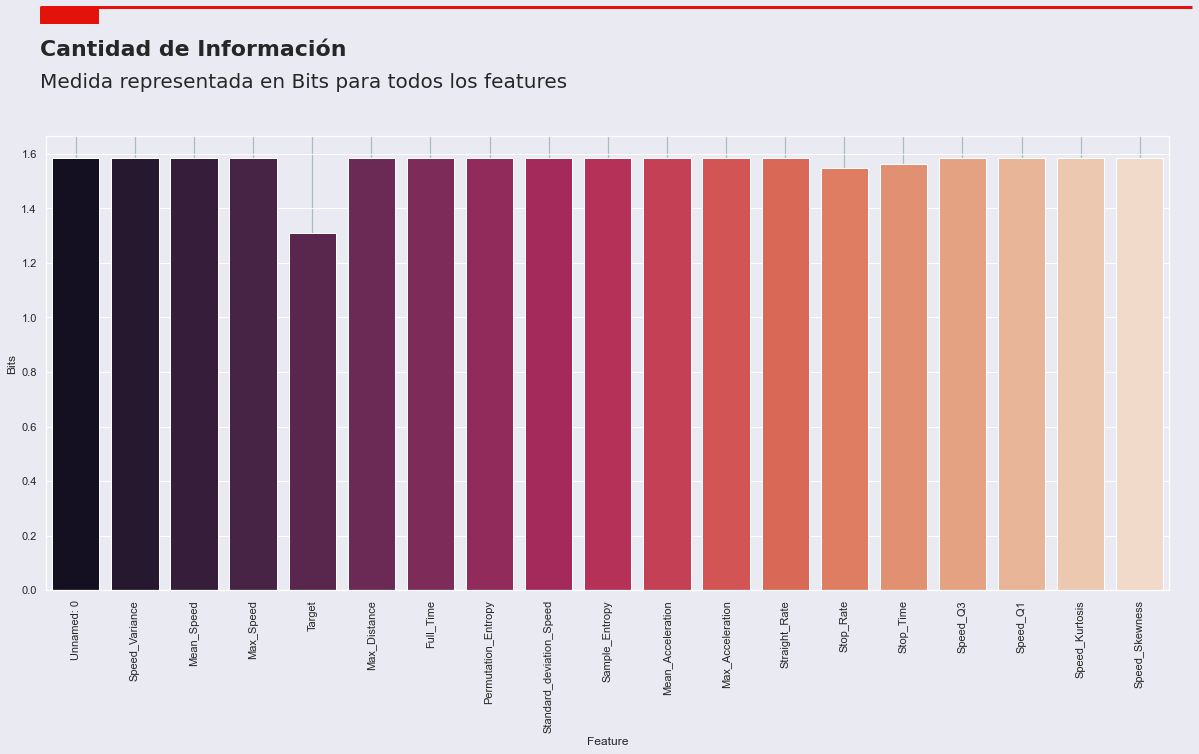

In [297]:
plot_df = pd.DataFrame(inf_dict.items())
plot_df

# The colors
BLUE = "#076fa2"
RED = "#E3120B"
BLACK = "#202020"
GREY = "#a2a2a2"

fig, ax = plt.subplots(figsize=(16,9))
fig.subplots_adjust(left=0.005, right=0.98, top=0.8, bottom=0.1)
ax = sns.barplot(x=0, y=1, data=plot_df,ci="sd",palette="rocket")
ax.set(xlabel = 'Feature', ylabel='Bits')
ax.tick_params(axis='x', rotation=90)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
# Add title
fig.text(
    0, 0.925, "Cantidad de Información", 
    fontsize=22, fontweight="bold", fontfamily="Econ Sans Cnd"
)
# Add subtitle
fig.text(
    0, 0.875, "Medida representada en Bits para todos los features", 
    fontsize=20, fontfamily="Econ Sans Cnd"
)
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], color = RED,lw=3, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color=RED))

# # Add caption
# source = "Dataset geolife "
# fig.text(
#     0, 0.06, source, color=GREY, 
#     fontsize=14, fontfamily="Econ Sans Cnd"
# )

# # Add authorship
# fig.text(
#     0, 0.005, "Kiril Morozov", color=GREY,
#     fontsize=16, fontfamily="Milo TE W01"
# )
fig.patch.set_facecolor("#eaeaf2")
#ax.set_facecolor('silver')
ax.set_facecolor(color="#eaeaf2")

## Información mútua <a name="informacionmutua"></a>

Para hablar de información mútua se introduce primero el concepto de entropía cruzazada: cantidad de información contenida en dos secuencias de datos cruzadas.

$$H(Y \mid X) = - \sum_{x} \sum_{y} p(x, y) \log p(y \mid x).$$

Por último la información mútua es una medida que se usa para saber cuánta información podemos podemos obtener de una variable conocida otra.

$$I(X, Y) = E_{x} E_{y} \left\{ p_{X, Y}(x, y) \log\frac{p_{X, Y}(x, y)}{p_X(x) p_Y(y)} \right\}. $$

Una visión global de las tres medidas que hemos visto se pueden observar en la siguiente figura:

<center><img src="https://d2l.ai/_images/mutual-information.svg" title="Shannon" width="30%" /></center>

La utilidad de esto, estriba en que habiendo un target a predecir, podemos averiguar hasta qué punto influye cada uno de los predictores del dataset en la predicción de ese targer ya sea para tareas de clasificación, regresión, etc.


Veámoslo:

In [311]:
#Información mútua entre dos columnas
print("Información mútua       ==>",round(mutual_information(df.Target.values, df.Full_Time.values),3),"bits")

    
def mutualInfoMatrix(df):
    columns = df.columns
    n = len(columns)
    mtrx = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(n):
            mtrx[i, j] = mutual_information(df[columns[i]].values, df[columns[j]].values)
    
    return mtrx

m = mutualInfoMatrix(df) #matriz de información mútua


Información mútua       ==> 1.204 bits


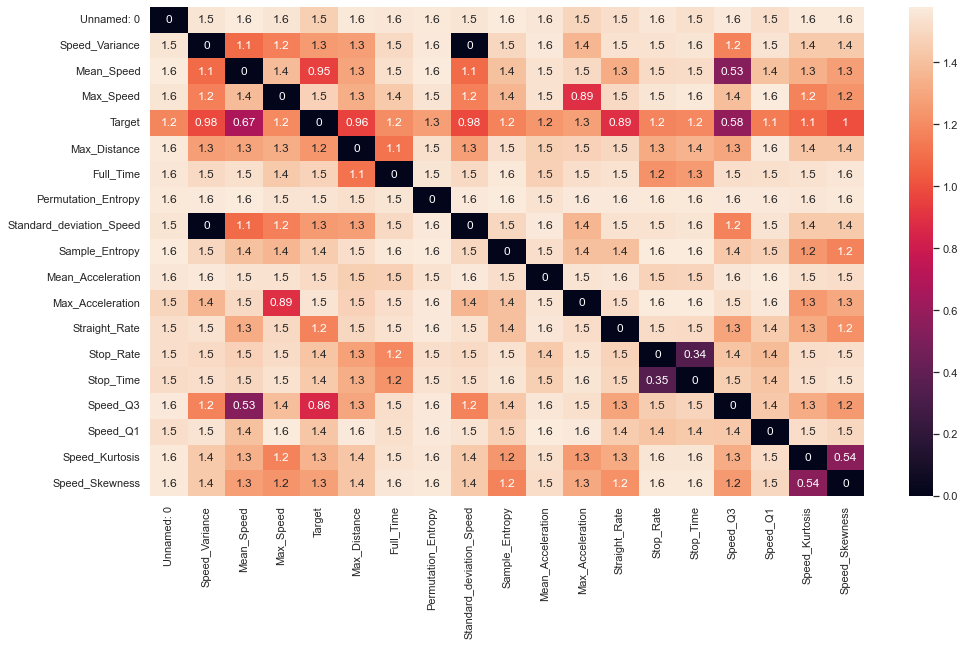

In [315]:
fig, ax = plt.subplots(figsize=(16,9))
ax = heatmap(m, annot=True, xticklabels=df.columns, yticklabels=df.columns)

## Ganancia de Información <a name="gananciainformacion"></a>

In [348]:
#Ganancia de Información
print("Ganancia de Información ==>",round(information_gain(df.Target, df.Full_Time),3),"bits")


def inf_gain_array(df):
    inf_gain = []
    for col in df.select_dtypes(include=["object","category"]):
       inf_gain.append([col,information_gain(df.Target,df[col])])
    return inf_gain

inf_gain = inf_gain_array(df)
print(inf_gain)

df_inf = pd.DataFrame(inf_gain) #first element of each element of list
df_inf.columns=["Variable","Ganancia"]
df_inf

Ganancia de Información ==> 0.106 bits
[['Unnamed: 0', 0.12816443517224263], ['Speed_Variance', 0.3312743640080583], ['Mean_Speed', 0.6370987489770916], ['Max_Speed', 0.11525264099195986], ['Target', 1.3098448279253185], ['Max_Distance', 0.34797989297357157], ['Full_Time', 0.10632475276540165], ['Permutation_Entropy', 0.04228723907608023], ['Standard_deviation_Speed', 0.3312743640080583], ['Sample_Entropy', 0.1404039716222225], ['Mean_Acceleration', 0.07564933820320707], ['Max_Acceleration', 0.0384459237337158], ['Straight_Rate', 0.41699340611755664], ['Stop_Rate', 0.1338052593465333], ['Stop_Time', 0.12506385916503437], ['Speed_Q3', 0.7266082090124651], ['Speed_Q1', 0.16263722251804147], ['Speed_Kurtosis', 0.2352536945289878], ['Speed_Skewness', 0.3137198843532032]]


,Variable,Ganancia
0,Unnamed: 0,0.128164
1,Speed_Variance,0.331274
2,Mean_Speed,0.637099
3,Max_Speed,0.115253
4,Target,1.309845
5,Max_Distance,0.347980
6,Full_Time,0.106325
7,Permutation_Entropy,0.042287
8,Standard_deviation_Speed,0.331274
9,Sample_Entropy,0.140404


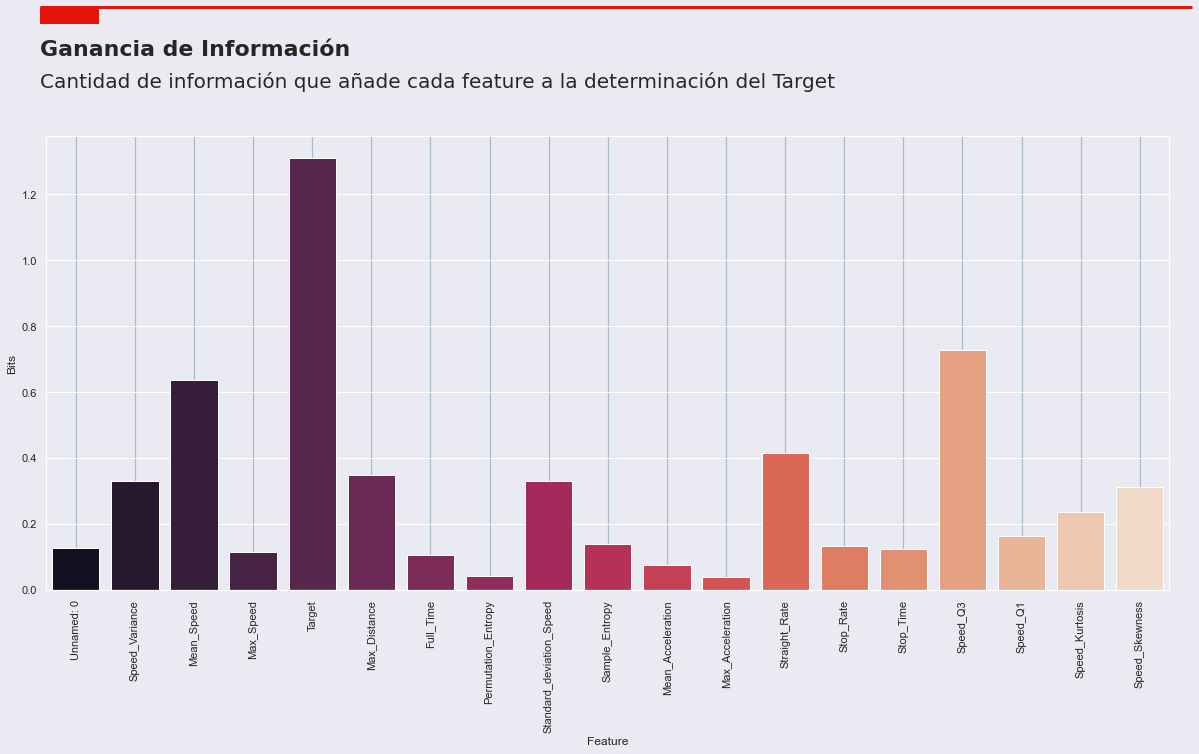

In [352]:
fig, ax = plt.subplots(figsize=(16,9))
fig.subplots_adjust(left=0.005, right=0.98, top=0.8, bottom=0.1)
ax = sns.barplot(x="Variable", y="Ganancia", data=df_inf,ci="sd",palette="rocket")
ax.set(xlabel = 'Feature', ylabel='Bits')
ax.tick_params(axis='x', rotation=90)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2)
# Add title
fig.text(
    0, 0.925, "Ganancia de Información", 
    fontsize=22, fontweight="bold", fontfamily="Econ Sans Cnd"
)
# Add subtitle
fig.text(
    0, 0.875, "Cantidad de información que añade cada feature a la determinación del Target", 
    fontsize=20, fontfamily="Econ Sans Cnd"
)
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], color = RED,lw=3, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color=RED))

# # Add caption
# source = "Dataset geolife "
# fig.text(
#     0, 0.06, source, color=GREY, 
#     fontsize=14, fontfamily="Econ Sans Cnd"
# )

# # Add authorship
# fig.text(
#     0, 0.005, "Kiril Morozov", color=GREY,
#     fontsize=16, fontfamily="Milo TE W01"
# )
fig.patch.set_facecolor("#eaeaf2")
#ax.set_facecolor('silver')
ax.set_facecolor(color="#eaeaf2")

## Clustering <a name="clustering"></a>

En las tareas de clasificación supervisada a menuda disponemos de muchos feautures o características. No todas son significativas para la tarea. Haciendo uso de ganancia de información como en el caso anterior podemos determinar que columnas son óptimas para el uso en clasificación.

In [304]:
# Custering con Dataset Iris
def iris_clusters(use_columns=None):
    iris = datasets.load_iris()
    model = KMeans(n_clusters=len(iris.target_names))
    if use_columns is None:
        data = iris.data
    else:
        data = iris.data[:, use_columns]
    model.fit(data)
    return iris.target, model.predict(data)

for use_columns in [[0], [0, 1], [0, 1, 2], [0, 1, 2, 3]]:
    actuals, modeled = iris_clusters(use_columns)
    print('Usando %d columnas de predictores, conditional entropy = %.2f bits, information gain = %.2f bits' % 
          (len(use_columns), mutual_information(actuals, modeled), information_gain(actuals, modeled)))

Usando 1 columnas de predictores, conditional entropy = 0.99 bits, information gain = 0.60 bits
Usando 2 columnas de predictores, conditional entropy = 0.56 bits, information gain = 1.02 bits
Usando 3 columnas de predictores, conditional entropy = 0.44 bits, information gain = 1.14 bits
Usando 4 columnas de predictores, conditional entropy = 0.39 bits, information gain = 1.19 bits


# Feature Selection  <a name="feature"></a>

Existen funciones en la libreria sklearn que ayudan a calcular información mútua tanto para problemas de regresión como para problemas de clasificación. Veamos un ejemplo:

In [355]:
from sklearn.feature_selection import mutual_info_classif          #Para problemas de clasificación
from sklearn.model_selection import train_test_split               
from sklearn.feature_selection import mutual_info_regression       #Para problemas de regresión




#vuelvo a cargar el dataset numérico
df = pd.read_csv(r'D:\[3]--Python Workdir--[3]\Data - ML- DL- projects\data\train\train.csv')

#Split
X_train,X_test,y_train,y_test=train_test_split(df.drop(labels=['Target'], axis=1),
    df['Target'],
    test_size=0.3,
    random_state=0)


mutual_info = mutual_info_classif(X_train.fillna(0), y_train)


mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

Speed_Q3                    0.666851
Mean_Speed                  0.536121
Standard_deviation_Speed    0.343924
Straight_Rate               0.342577
Speed_Variance              0.331854
Max_Distance                0.307908
Speed_Kurtosis              0.231879
Speed_Q1                    0.228250
Max_Speed                   0.219500
Sample_Entropy              0.205932
Speed_Skewness              0.175975
Full_Time                   0.082766
Unnamed: 0                  0.069137
Max_Acceleration            0.039591
Stop_Rate                   0.033721
Mean_Acceleration           0.032117
Stop_Time                   0.019781
Permutation_Entropy         0.000000
dtype: float64

<AxesSubplot:>

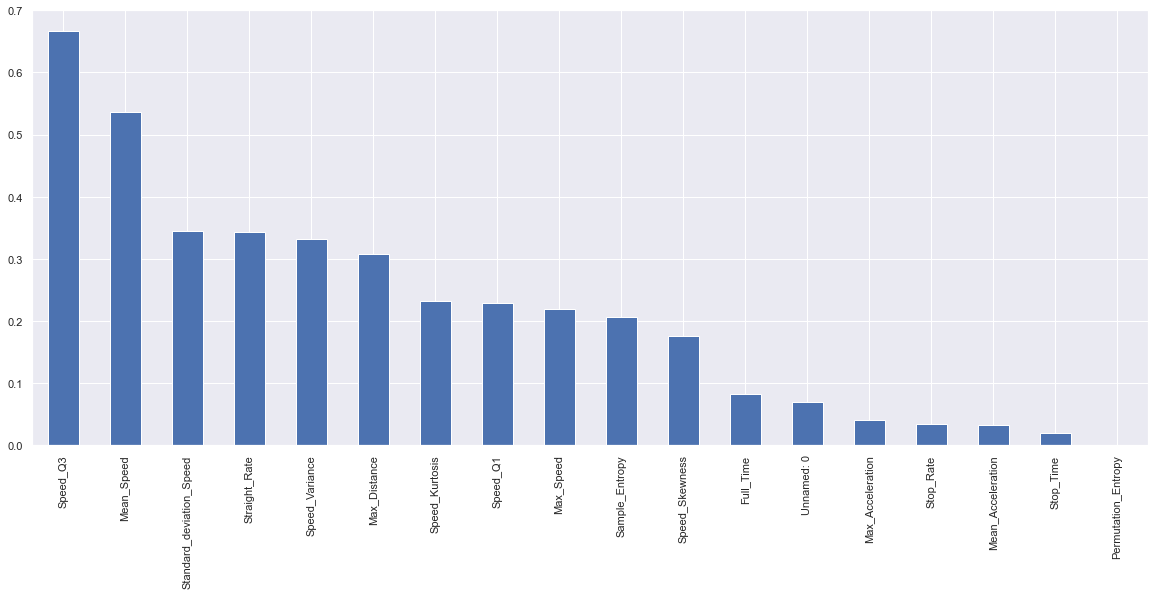

In [356]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

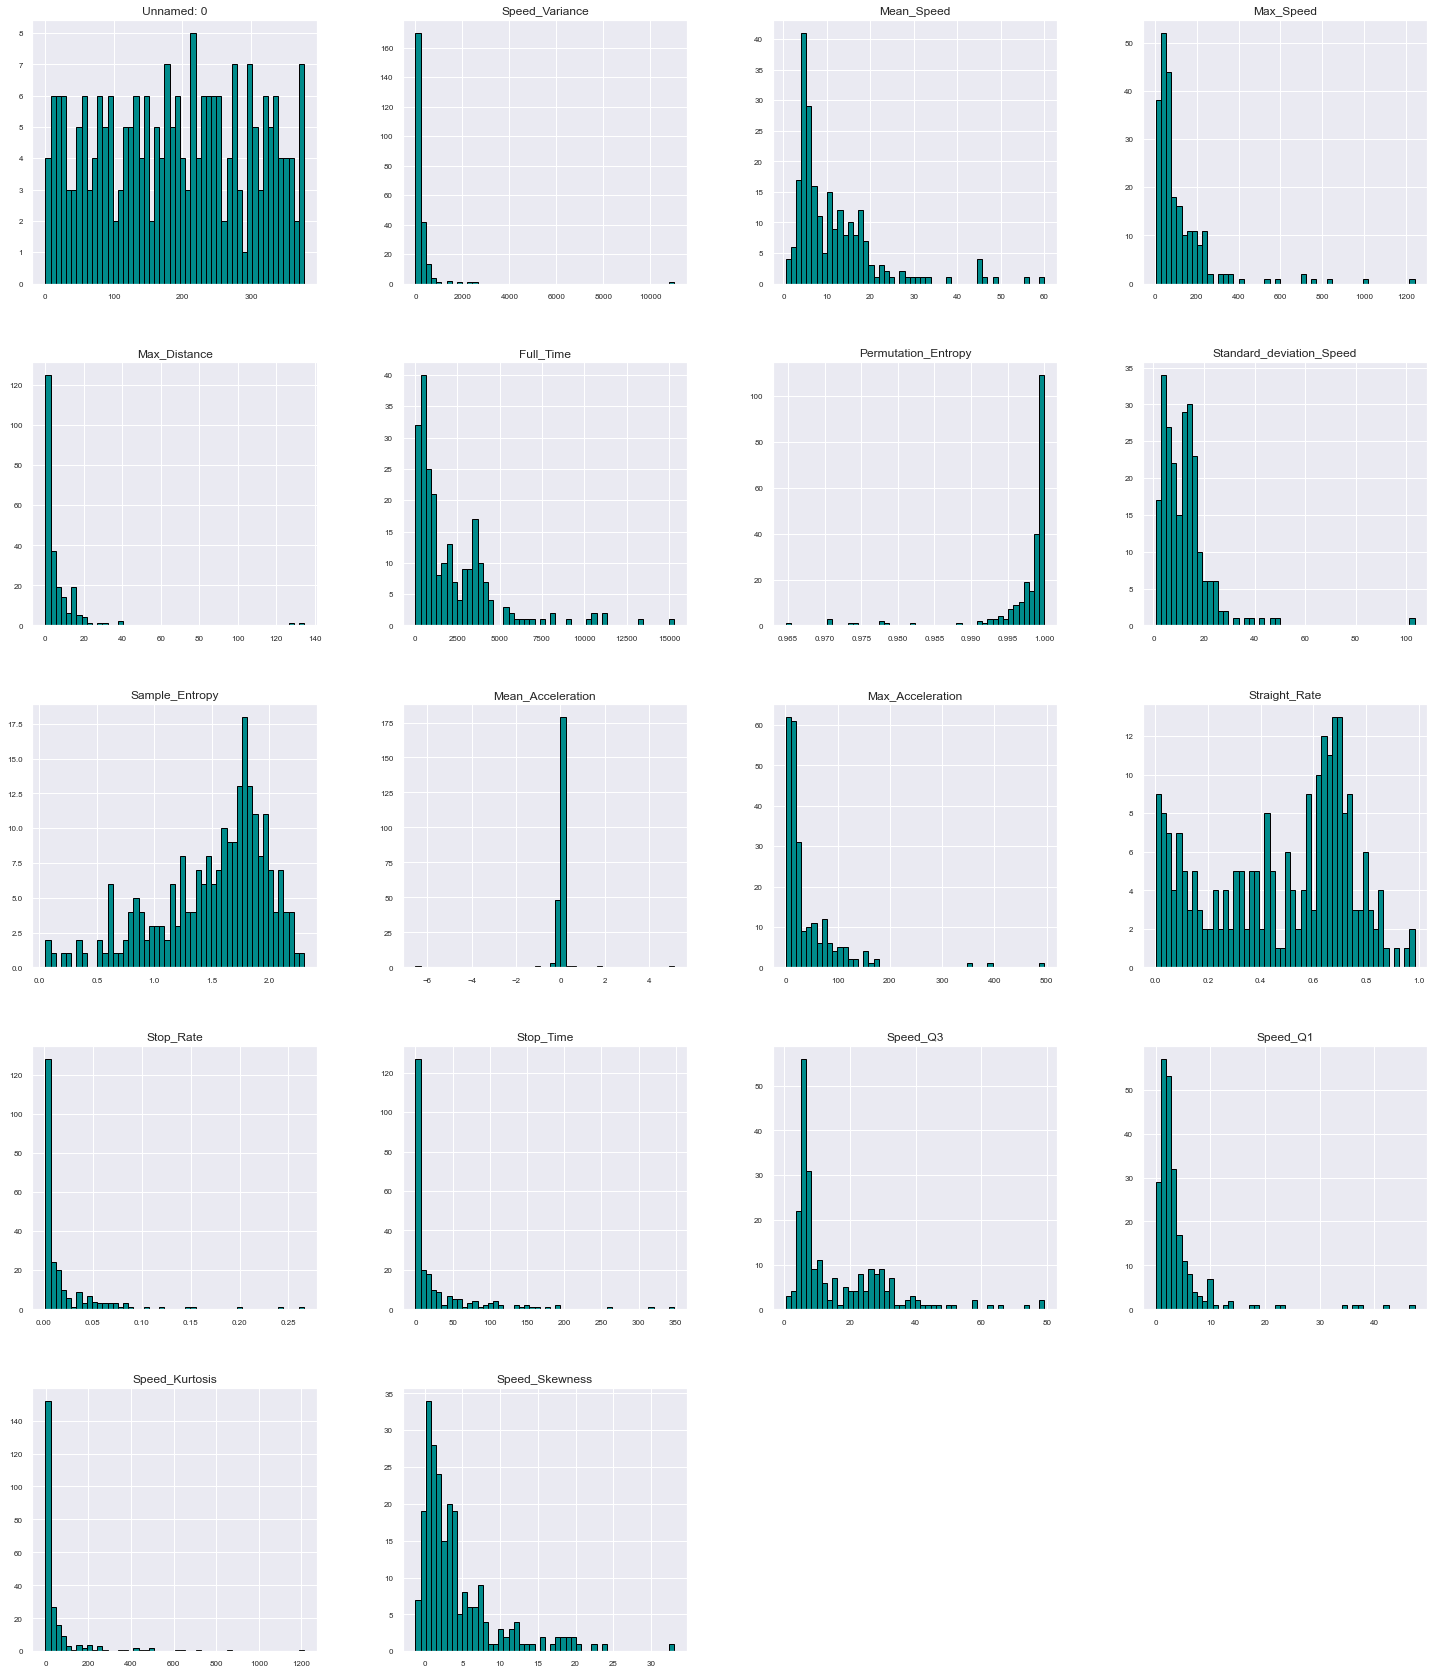

In [358]:
#Distribuciones de todas las varibles numéricas

fig_ = df.hist(figsize=(25, 30), bins=50, color="darkcyan", edgecolor="black", xlabelsize=8, ylabelsize=8)

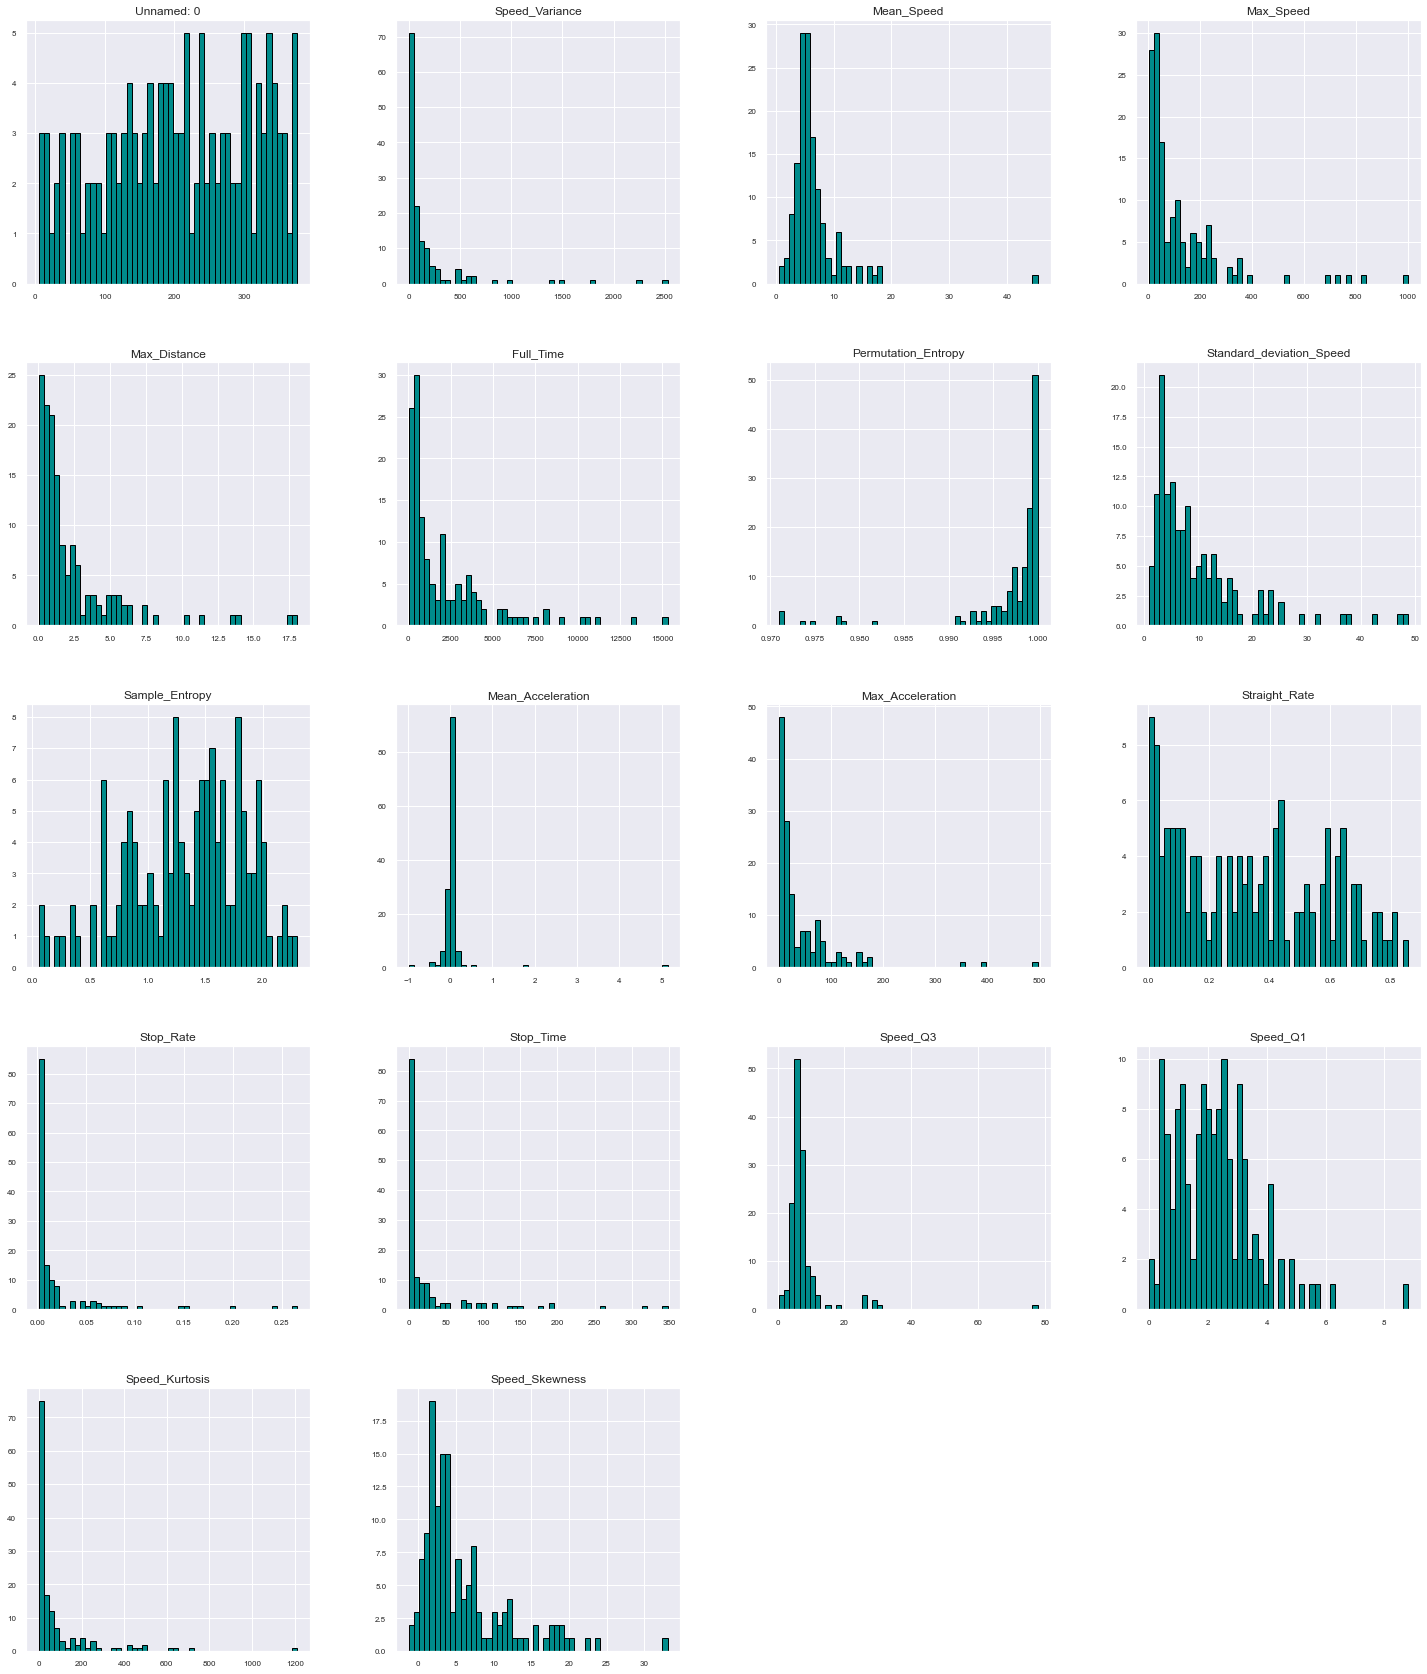

In [362]:
fig_ = df[df["Target"]=="walk"].hist(figsize=(25, 30), bins=50, color="darkcyan", edgecolor="black", xlabelsize=8, ylabelsize=8)

In [357]:
import session_info
session_info.show()